In [ ]:
"""
Task 2: Sentiment and Thematic Analysis Pipeline

This script loads the balanced and cleaned review data from Task 1,
applies pre-trained Hugging Face DistilBERT for sentiment analysis,
and extracts themes using a rule-based keyword approach.


It aggregates the final results and saves an enriched CSV for reporting.
"""

import pandas as pd
import logging
import os
import sys
import re
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# We will use the 'emoji' library for conversion.
# Ensure 'pip install emoji' is run if you use this code outside the current environment.
try:
    import emoji
except ImportError:
    # If the library is not available, we define a fallback function
    def emojize(text, language='en', delimiters=(':', ':'), variant=None):
        return text
    logging.warning("The 'emoji' library is not installed. Emoji conversion will be skipped.")


# --- Configuration ---
# Safely determine the project root, accounting for environments where __file__ is not defined (like notebooks).
try:
    SCRIPT_PATH = os.path.abspath(__file__)
    # Navigate three levels up from the script location (src/analysis/task_2_nlp_analysis.py -> PROJECT_ROOT)
    PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.dirname(SCRIPT_PATH)))
except NameError:
    # Fallback for environments where __file__ is not defined (like notebooks).
    # Assumes the execution is happening one directory level below the project root (e.g., inside 'notebooks').
    PROJECT_ROOT = os.path.dirname(os.getcwd()) 
    logging.warning(
        "Could not determine script location via '__file__'. Assuming project root is one level up from "
        f"current working directory: {PROJECT_ROOT}"
    )

DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

INPUT_FILENAME = "final_bank_reviews_constrained.csv"
OUTPUT_FILENAME = "reviews_with_sentiment_themes.csv"
AGGREGATED_FILENAME = "aggregated_bank_insights.csv"

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# Enable progress bar for pandas apply/iteration
tqdm.pandas()

# --- Thematic Keyword Definitions (Rule-Based Clustering) ---
# These keywords and phrases are mapped to the 5 requested overarching themes.
THEME_MAPPING = {
    # 1. Account Access Issues
    'Account Access Issues': [
        'login error', 'cannot log', 'forgot password', 'pin', 'username', 
        'fingerprint', 'face id', 'access problem', 'locked out', 'security code', 
        'authentication', 'registration', 'session'
    ],
    # 2. Transaction Performance
    'Transaction Performance': [
        'slow', 'transfer fail', 'transaction fail', 'delay', 'stuck', 
        'pending', 'not delivered', 'speed', 'instantly', 'fast', 
        'loading', 'crash', 'bugs', 'down', 'lag'
    ],
    # 3. User Interface & Experience
    'User Interface & Experience': [
        'ui', 'user interface', 'design', 'layout', 'simple', 'confusing', 
        'easy to use', 'navigation', 'experience', 'complex', 'smooth', 
        'modern look', 'friendly', 'thumbs up', 'star' # Added 'thumbs up' and 'star'
    ],
    # 4. Customer Support
    'Customer Support': [
        'customer service', 'support team', 'call center', 'help desk', 
        'response', 'contact', 'reach out', 'fix', 'problem solved', 'unresponsive'
    ],
    # 5. Feature Requests & General
    'Feature Requests & General': [
        'wishlist', 'new feature', 'budgeting', 'saving goal', 'update', 
        'card management', 'virtual card', 'future', 'add', 'please include', 'thank you', 'love it' # Added general positive/request terms
    ]
}

def load_data(filepath: str) -> pd.DataFrame:
    """Loads the final constrained review data."""
    try:
        df = pd.read_csv(filepath, encoding='utf-8')
        df.reset_index(names=['review_id_generated'], inplace=True)
        logger.info(f"Loaded {len(df)} constrained reviews for NLP analysis.")
        return df
    except FileNotFoundError:
        logger.error(f"Input file not found: {filepath}. Run Task 1 preprocessing first.")
        return pd.DataFrame()
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()
        
def convert_emojis(text: str) -> str:
    """Converts emojis in the text to their textual descriptions."""
    if 'emoji' in sys.modules:
        # Replace emojis with their standard CLDR shortcodes (e.g., 👍 becomes :thumbs_up:)
        text_with_shortcodes = emoji.demojize(text, delimiters=(" :", ": "))
        # Replace shortcodes with plain text (e.g., :thumbs_up: becomes thumbs_up)
        return text_with_shortcodes.replace(" :", " ").replace(": ", " ").replace(":", "")
    return text

def fallback_vader_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs sentiment analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner) 
    as a robust fallback when the deep learning model (DistilBERT) fails to load.
    """
    logger.warning("Falling back to VADER sentiment analysis due to missing deep learning libraries.")
    try:
        # Attempt to download VADER lexicon data
        nltk.download('vader_lexicon', quiet=True)
    except Exception as e:
        logger.error(f"Failed to download NLTK VADER lexicon: {e}. Check internet connection/NLTK setup.")
        # We proceed anyway, VADER might still work if the lexicon is already present.

    sia = SentimentIntensityAnalyzer()
    
    def get_vader_sentiment(text):
        """Maps VADER compound score to POSITIVE, NEUTRAL, or NEGATIVE labels."""
        if pd.isna(text) or not text.strip():
            return 'NEUTRAL', 0.0
            
        score = sia.polarity_scores(text)['compound']
        
        # Standard VADER classification thresholds
        if score >= 0.05:
            return 'POSITIVE', score
        elif score <= -0.05:
            return 'NEGATIVE', score
        else:
            return 'NEUTRAL', score

    # Apply VADER analysis on the preprocessed text
    vader_results = df['review_preprocessed'].progress_apply(get_vader_sentiment)
    
    # Unpack the results into the required columns
    df[['sentiment_label', 'sentiment_score']] = pd.DataFrame(vader_results.tolist(), index=df.index)
    
    logger.info("Sentiment Analysis complete using VADER (Fallback).")
    return df

def run_sentiment_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the preferred DistilBERT model. Falls back to VADER if the model cannot be loaded.
    """
    
    # 1. Pre-process the reviews: Convert emojis to text
    df['review_preprocessed'] = df['review'].progress_apply(convert_emojis)
    logger.info("Emoji conversion complete.")
    
    # Initialize the sentiment analysis pipeline
    try:
        logger.info("Attempting to load DistilBERT sentiment model...")
        sentiment_pipeline = pipeline(
            "sentiment-analysis", 
            model="distilbert-base-uncased-finetuned-sst-2-english"
        )
        
        # Process the preprocessed reviews
        review_texts = df['review_preprocessed'].tolist()
        
        # Use tqdm to show progress during the time-consuming analysis step
        results = sentiment_pipeline(tqdm(review_texts, desc="Analyzing Sentiment (DistilBERT)"))
        
        # Extract results
        df['sentiment_label'] = [res['label'] for res in results]
        df['sentiment_score'] = [res['score'] for res in results]
        
        logger.info("Sentiment Analysis complete using DistilBERT.")
        return df

    except Exception as e:
        # This catches errors when PyTorch/TensorFlow are missing, or internet issues
        logger.error(f"Failed to load Hugging Face model. Error: {e}")
        # 2. Fallback to VADER
        return fallback_vader_analysis(df)
        

def assign_theme(review_text: str) -> str:
    """
    Assigns a primary theme to a review based on keyword matching (Rule-Based Clustering).
    The theme with the most matched keywords wins.
    """
    if pd.isna(review_text):
        return 'Unclassified'
        
    text_lower = review_text.lower()
    
    # Initialize score tracking for themes
    theme_scores = {theme: 0 for theme in THEME_MAPPING.keys()}
    
    # Check for keyword matches
    for theme, keywords in THEME_MAPPING.items():
        for keyword in keywords:
            # Use regex word boundary to match whole words/phrases accurately
            if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
                theme_scores[theme] += 1
                
    # Determine the theme with the highest score
    # Filter out themes with zero scores
    positive_scores = {theme: score for theme, score in theme_scores.items() if score > 0}
    
    if positive_scores:
        # Get theme(s) with the maximum score
        max_score = max(positive_scores.values())
        best_themes = [theme for theme, score in positive_scores.items() if score == max_score]
        
        # If multiple themes have the same max score, return the first one found, 
        # or a composite label if you prefer, but sticking to one is simpler for initial analysis.
        return best_themes[0]
    else:
        return 'General Feedback'

def run_thematic_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the rule-based theme assignment to all reviews, using the preprocessed text.
    """
    logger.info("Starting Rule-Based Thematic Analysis on preprocessed text...")
    
    # Use the 'review_preprocessed' column (which has text instead of emojis) for theme assignment
    df['identified_theme'] = df['review_preprocessed'].progress_apply(assign_theme)
    
    # Optional: Display top N-grams to verify theme keywords (not saved in DF)
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=50)
    try:
        tfidf_matrix = vectorizer.fit_transform(df['review_preprocessed'])
        feature_names = vectorizer.get_feature_names_out()
        logger.info(f"Top 10 keywords/n-grams (TF-IDF): {feature_names[:10].tolist()}")
    except ValueError:
        logger.warning("Could not compute TF-IDF (empty vocabulary).")


    logger.info("Thematic Analysis complete.")
    return df

def aggregate_insights(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates sentiment and theme data by bank and rating for high-level insights.
    """
    logger.info("Aggregating insights by Bank and Rating...")
    
    # 1. Prepare numerical representation for sentiment
    # Map POSITIVE=1, NEUTRAL=0, NEGATIVE=-1 for a better average index calculation across all three labels
    df['sentiment_numeric'] = df['sentiment_label'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}).fillna(0)
    
    # 2. Group and calculate key metrics
    agg_df = df.groupby(['bank', 'rating']).agg(
        total_reviews=('review', 'count'),
        # Mean sentiment score: 1=Positive, 0=Neutral, -1=Negative
        mean_sentiment_score=('sentiment_numeric', 'mean'), 
        median_rating=('rating', 'median'),
        top_theme=('identified_theme', lambda x: x.mode()[0]) # Find the most frequent theme
    ).reset_index()
    
    # Rename for clarity
    agg_df.rename(columns={'mean_sentiment_score': 'Avg_Sentiment_Index (-1 to 1)'}, inplace=True)
    
    logger.info("Aggregation complete. Resulting table shows key metrics per bank and rating.")
    return agg_df


def main():
    """Main function to run the NLP analysis pipeline."""
    input_filepath = os.path.join(DATA_PROCESSED_PATH, INPUT_FILENAME)
    output_filepath = os.path.join(DATA_PROCESSED_PATH, OUTPUT_FILENAME)
    aggregated_filepath = os.path.join(DATA_PROCESSED_PATH, AGGREGATED_FILENAME)
    
    # 1. Load Data
    df = load_data(input_filepath)
    if df.empty:
        return 
        
    # 2. Sentiment Analysis (Includes Emoji Conversion and VADER Fallback)
    df_sentiment = run_sentiment_analysis(df)

    # 3. Thematic Analysis (Keyword/Rule-Based Clustering)
    # We rename it directly to df_final to keep the 'review_preprocessed' column
    df_final = run_thematic_analysis(df_sentiment)
    
    # NOTE: The 'review_preprocessed' column is intentionally kept in df_final
    # as requested, to allow comparison with the original 'review' column.

    # 4. Aggregate Insights
    df_aggregated = aggregate_insights(df_final.copy())
    
    # 5. Save Final Results
    df_final.to_csv(output_filepath, index=False, encoding='utf-8')
    logger.info(f"💾 Saved enriched individual reviews to {output_filepath}")
    
    df_aggregated.to_csv(aggregated_filepath, index=False, encoding='utf-8')
    logger.info(f"💾 Saved aggregated insights to {aggregated_filepath}")

    logger.info("\n✨ Task 2 Pipeline Complete. Data is ready for Visualization (Task 4) and Storage (Task 3).")

if __name__ == "__main__":
    main()

100%|██████████| 1884/1884 [00:00<00:00, 6306.57it/s]
ERROR:__main__:Failed to load Hugging Face model. Error: name 'torch' is not defined
100%|██████████| 1884/1884 [00:02<00:00, 850.71it/s] 


In [14]:
"""
Task 2 Results Summary: Numerical Presentation

This script reads the aggregated insights CSV generated by the Task 2 pipeline 
and prints key numerical findings to the console.
"""
import pandas as pd
import os
import sys

# Safely determine the project root
try:
    SCRIPT_PATH = os.path.abspath(__file__)
    PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.dirname(SCRIPT_PATH)))
except NameError:
    # Fallback for environments where __file__ is not defined (like notebooks).
    PROJECT_ROOT = os.path.dirname(os.getcwd()) 

DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')
AGGREGATED_FILENAME = "aggregated_bank_insights.csv"
INPUT_FILEPATH = os.path.join(DATA_PROCESSED_PATH, AGGREGATED_FILENAME)


def display_numerical_results():
    """Reads the aggregated data and prints key numerical insights."""
    print("--- Task 2: Numerical Analysis Results ---")
    
    try:
        df_agg = pd.read_csv(INPUT_FILEPATH, encoding='utf-8')
        
        if df_agg.empty:
            print(f"Error: Aggregated data file is empty: {INPUT_FILEPATH}")
            return
            
        print(f"Data loaded from: {INPUT_FILEPATH}\n")
        
        # 1. Overall Bank Performance Summary (Mean Sentiment Index)
        overall_performance = df_agg.groupby('bank')['Avg_Sentiment_Index (-1 to 1)'].mean().sort_values(ascending=False)
        print("1. Average Overall Sentiment Index per Bank (Max 1.0, Min -1.0):")
        print(overall_performance.to_markdown(floatfmt=".3f"))
        print("\n" + "="*50 + "\n")

        # 2. Critical Review (1-Star) Pain Points
        df_1_star = df_agg[df_agg['rating'] == 1].sort_values(by='Avg_Sentiment_Index (-1 to 1)')
        
        print("2. Critical (1-Star) Review Analysis:")
        print("   Average Sentiment Index and Top Theme for 1-Star Reviews:\n")
        
        critical_insights = df_1_star[[
            'bank', 
            'Avg_Sentiment_Index (-1 to 1)', 
            'total_reviews', 
            'top_theme'
        ]].rename(columns={'Avg_Sentiment_Index (-1 to 1)': '1-Star Avg Sentiment', 'total_reviews': '1-Star Count'})
        
        print(critical_insights.to_markdown(index=False, floatfmt=".3f"))
        print("\n" + "="*50 + "\n")
        
        # 3. Top Theme for Positive Reviews (5-Star)
        df_5_star = df_agg[df_agg['rating'] == 5].sort_values(by='Avg_Sentiment_Index (-1 to 1)', ascending=False)
        
        print("3. Positive (5-Star) Review Driver Analysis:")
        print("   Top Theme Driving 5-Star Satisfaction:\n")
        
        positive_insights = df_5_star[[
            'bank', 
            'Avg_Sentiment_Index (-1 to 1)', 
            'total_reviews', 
            'top_theme'
        ]].rename(columns={'Avg_Sentiment_Index (-1 to 1)': '5-Star Avg Sentiment', 'total_reviews': '5-Star Count'})
        
        print(positive_insights.to_markdown(index=False, floatfmt=".3f"))
        print("\n--- Numerical Summary Complete ---")
        
    except FileNotFoundError:
        print(f"ERROR: Aggregated file not found at {INPUT_FILEPATH}.")
        print("Please ensure you successfully ran the Task 2 NLP analysis script first.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

if __name__ == "__main__":
    display_numerical_results()

--- Task 2: Numerical Analysis Results ---
Data loaded from: c:\Users\ADMIN\Desktop\KALEB\10Academy\Week2\fintech-reviews-analysis\data\processed\aggregated_bank_insights.csv

1. Average Overall Sentiment Index per Bank (Max 1.0, Min -1.0):
| bank   |   Avg_Sentiment_Index (-1 to 1) |
|:-------|--------------------------------:|
| Dashen |                           0.351 |
| CBE    |                           0.296 |
| BOA    |                           0.237 |


2. Critical (1-Star) Review Analysis:
   Average Sentiment Index and Top Theme for 1-Star Reviews:

| bank   |   1-Star Avg Sentiment |   1-Star Count | top_theme        |
|:-------|-----------------------:|---------------:|:-----------------|
| BOA    |                 -0.351 |            359 | General Feedback |
| CBE    |                 -0.205 |            127 | General Feedback |
| Dashen |                 -0.184 |             76 | General Feedback |


3. Positive (5-Star) Review Driver Analysis:
   Top Theme Driving 5-St

🔍 TASK 2 DETAILED RESULTS SUMMARY

📊 1. SENTIMENT DISTRIBUTION BY BANK
sentiment_label  NEGATIVE  NEUTRAL  POSITIVE
bank                                        
BOA                 34.14    23.71     42.14
CBE                 15.00    20.14     64.86
Dashen              11.78    15.08     73.14

🎯 2. MOST COMMON THEMES BY BANK

BOA:
  - General Feedback: 485 reviews (69.3%)
  - Transaction Performance: 84 reviews (12.0%)
  - Feature Requests & General: 52 reviews (7.4%)

CBE:
  - General Feedback: 498 reviews (71.1%)
  - Feature Requests & General: 60 reviews (8.6%)
  - User Interface & Experience: 55 reviews (7.9%)

Dashen:
  - General Feedback: 277 reviews (57.2%)
  - User Interface & Experience: 97 reviews (20.0%)
  - Transaction Performance: 72 reviews (14.9%)

📈 3. RATING VS SENTIMENT CORRELATION
rating
1   -0.178
2   -0.038
3    0.204
4    0.340
5    0.500
Name: sentiment_score, dtype: float64

📊 GENERATING VISUALIZATIONS...


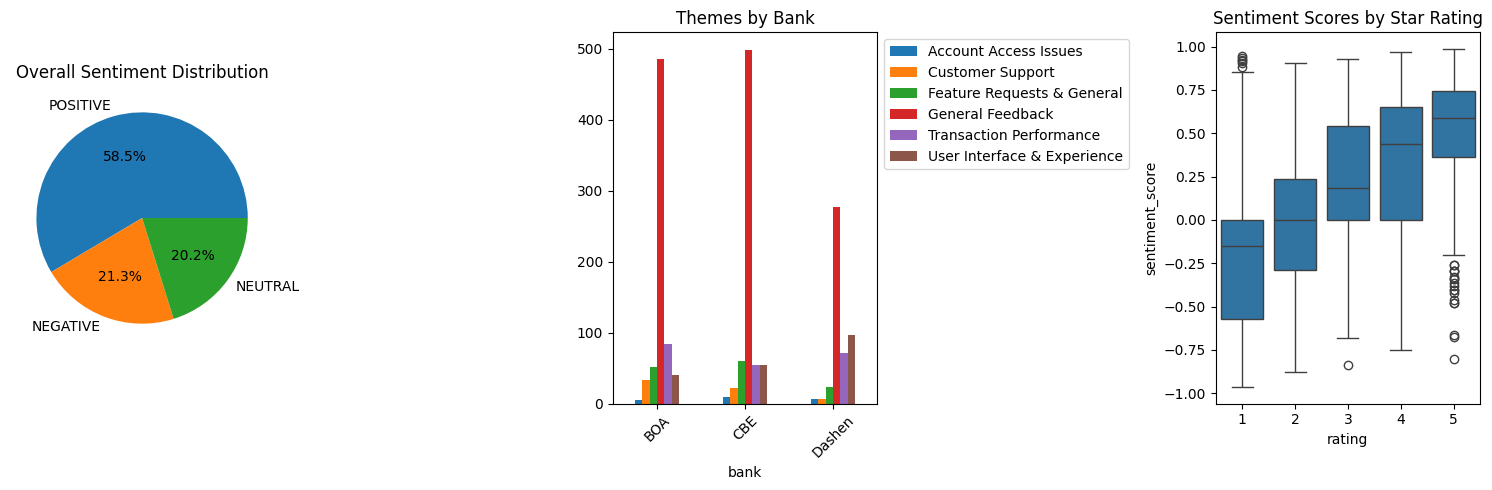


🔤 4. TOP KEYWORDS FOUND
Most frequent words in reviews:
  - 'this': 453 times
  - 'very': 239 times
  - 'good': 227 times
  - 'bank': 216 times
  - 'with': 200 times
  - 'banking': 189 times
  - 'it's': 188 times
  - 'best': 159 times
  - 'have': 149 times
  - 'please': 140 times

✅ TASK 2 ANALYSIS COMPLETE!
📁 Data loaded from: c:\Users\ADMIN\Desktop\KALEB\10Academy\Week2\fintech-reviews-analysis\data\processed\reviews_with_sentiment_themes.csv


In [12]:
"""
Task 2 Results Summary - Extended Analysis
Run this AFTER completing the main Task 2 pipeline to see detailed findings.
Adjusted for notebook environment and your project structure.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Configuration - Adjusted for your structure
PROJECT_ROOT = os.path.dirname(os.getcwd())  # Goes up from notebooks folder to project root
DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

def display_detailed_results():
    """Shows comprehensive Task 2 results with visualizations"""
    
    try:
        # Load the enriched data
        file_path = os.path.join(DATA_PROCESSED_PATH, "reviews_with_sentiment_themes.csv")
        df = pd.read_csv(file_path)
        
        print("🔍 TASK 2 DETAILED RESULTS SUMMARY")
        print("=" * 60)
        
        # 1. Sentiment Distribution by Bank
        print("\n📊 1. SENTIMENT DISTRIBUTION BY BANK")
        sentiment_summary = pd.crosstab(df['bank'], df['sentiment_label'], normalize='index') * 100
        print(sentiment_summary.round(2))
        
        # 2. Theme Analysis
        print("\n🎯 2. MOST COMMON THEMES BY BANK")
        for bank in df['bank'].unique():
            bank_themes = df[df['bank'] == bank]['identified_theme'].value_counts()
            print(f"\n{bank}:")
            for theme, count in bank_themes.head(3).items():
                print(f"  - {theme}: {count} reviews ({count/len(df[df['bank']==bank])*100:.1f}%)")
        
        # 3. Rating vs Sentiment Correlation
        print("\n📈 3. RATING VS SENTIMENT CORRELATION")
        rating_sentiment = df.groupby('rating')['sentiment_score'].mean()
        print(rating_sentiment.round(3))
        
        # 4. Create Visualizations
        print("\n📊 GENERATING VISUALIZATIONS...")
        
        # Plot 1: Sentiment Distribution
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        sentiment_counts = df['sentiment_label'].value_counts()
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Overall Sentiment Distribution')
        
        # Plot 2: Themes by Bank
        plt.subplot(1, 3, 2)
        theme_by_bank = pd.crosstab(df['bank'], df['identified_theme'])
        theme_by_bank.plot(kind='bar', ax=plt.gca())
        plt.title('Themes by Bank')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1, 1))
        
        # Plot 3: Sentiment Scores by Rating
        plt.subplot(1, 3, 3)
        sns.boxplot(data=df, x='rating', y='sentiment_score')
        plt.title('Sentiment Scores by Star Rating')
        
        plt.tight_layout()
        plt.show()
        
        # 5. Keyword Insights
        print("\n🔤 4. TOP KEYWORDS FOUND")
        all_reviews = ' '.join(df['review_preprocessed'].dropna())
        words = [word for word in all_reviews.lower().split() if len(word) > 3]
        common_words = Counter(words).most_common(10)
        print("Most frequent words in reviews:")
        for word, count in common_words:
            print(f"  - '{word}': {count} times")
        
        print(f"\n✅ TASK 2 ANALYSIS COMPLETE!")
        print(f"📁 Data loaded from: {file_path}")
        
    except FileNotFoundError:
        print(f"❌ ERROR: File not found at {DATA_PROCESSED_PATH}")
        print("Please run the main Task 2 script first to generate the analysis files.")
    except Exception as e:
        print(f"❌ ERROR: {e}")

# Run the analysis
display_detailed_results()